In [2]:
import numpy as np 
import matplotlib.pylab as plt
from tqdm.auto import tqdm
from pint import UnitRegistry
%config InlineBackend.figure_format = 'retina'

\begin{align}
K_{ij} =& \kappa e^{-\beta E_{ij}}\\
\frac{\partial \phi_i}{\partial t} =& \sum_j (K_{ij}\phi_j - K_{ji}\phi_i)
\end{align}

$$ \sum_nK_{ni}\delta_{ij}- K_{ij} = A_{ij}$$

\begin{align}
\frac{\partial \phi_i}{\partial t} =& \sum_jA_{ij}\phi_j + J_i e^{-\rho t}\\
M^{-1}\frac{\partial\phi}{\partial t}+ \Lambda M^{-1}\phi =& M^{-1}J e^{-\rho t}\\
\frac{\partial\psi_i}{\partial t}+ \Lambda_i \psi_i =& \Xi_i e^{-\rho t}\\
\end{align}

\begin{align}
\psi_i(t) = \psi_i^0e^{-\Lambda_i t}+\frac{\Xi_i}{\Lambda_i - \rho}(e^{-\rho t}-e^{-\Lambda_i t})
\end{align}

\begin{align}
\phi_i(t) =& M_{ji} \psi^0_je^{-\Lambda_j t}\\
=& M_{ji} M_{jk}\phi^0_ke^{-\Lambda_j t}
\end{align}

In [75]:
def get_K(N, M, T, E_fcc, E_bcc, kappa, x_interface):
    indices = np.arange(N * M)
    indices_mat = indices.reshape((N, M))
    ureg = UnitRegistry()
    kBT = (T * ureg.kelvin * ureg.boltzmann_constant).to('eV').magnitude
    K = np.zeros(2*[len(indices)])
    logkappa = np.log(kappa)
    ind_interface = np.rint(x_interface * M).astype(int)
    E = np.ones((N, M)) * E_fcc
    E[:, :ind_interface] = E_bcc
    for shift in [-1, 1]:
        j = indices_mat.flatten()
        i = np.roll(indices_mat, shift, axis=0).flatten()
        K[i, j] = np.exp(-E.flatten() / kBT + logkappa)
    j = indices_mat[:, 1:-1].flatten()
    i = indices_mat[:, :-2].flatten()
    K[i, j] = np.exp(-E[:, 1:-1].flatten() / kBT + logkappa)
    i = indices_mat[:, 2:].flatten()
    K[i, j] = np.exp(-E[:, 1:-1].flatten() / kBT + logkappa)
    return K

In [91]:
T = 300
multi = 1
N = 20
MM = multi * N
E_fcc = 0.42
E_bcc = 0.05
# E_bcc = E_fcc
kappa = 10**(13)
x_interface = 0.5
# for T in [300, 400]:
K = get_K(N, MM, T, E_fcc, E_bcc, kappa, x_interface)
A = K.sum(axis=0) * np.eye(len(K)) - K
omega, M = np.linalg.eig(A)


In [168]:
# phi = 0.0001 * np.ones((N, MM))
phi = np.zeros((N, MM))
phi[0, 5] = 0

In [200]:
t = 1.0e-0
J = np.zeros_like(phi)
J[:, 1] = 0.1
rho = 0.0001
def get_phi_final(t, phi=phi, J=J, rho=rho, M=M, omega=omega):
    phi_final = np.einsum(
        'ij,jk,k,j->i', M, np.linalg.inv(M), phi.flatten(), np.exp(-omega * t), optimize=True
    ).reshape(phi.shape).real
    Xi = np.einsum('jk,k->j', np.linalg.inv(M), J.flatten())
    Xi /= omega - rho
    Xi *= np.exp(-rho * t) - np.exp(-omega * t)
    phi_final += np.einsum('ij,j->i', M, Xi).real.reshape(phi.shape)
    return phi_final

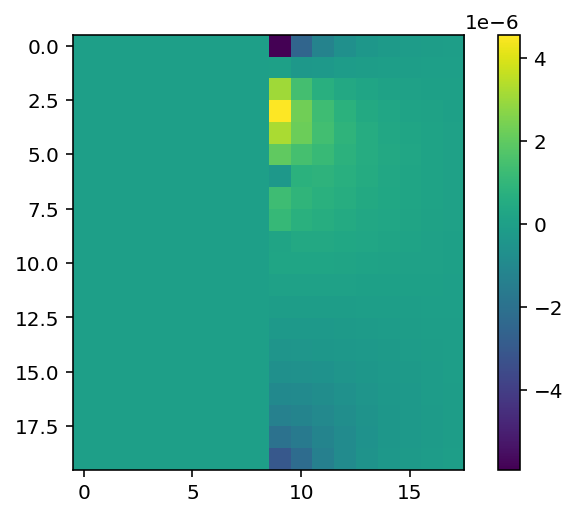

In [216]:
plt.imshow(get_phi_final(10000)[:, 1:-1]);
plt.colorbar()

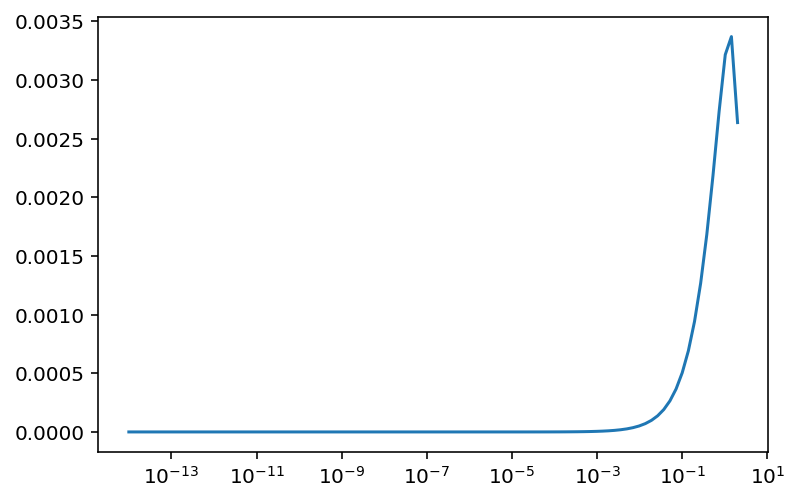

In [204]:
t = np.logspace(-14, 0.3, 100)
phi_release = [get_phi_final(tt)[:,-1].mean() for tt in t]
plt.xscale('log')
plt.plot(t, phi_release);